<a href="https://colab.research.google.com/github/saurabkunwar/NeuralNetworkFromScratch/blob/main/Skimlit_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preperation

In [61]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [62]:
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import create_optimizer
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification

In [64]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [65]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [66]:
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [67]:
def get_lines(filename):
  with open(filename, 'r') as f:
    return f.readlines()

In [68]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [69]:
def text_with_line_number(filename):
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [70]:
train_samples = text_with_line_number(data_dir+"train.txt")
val_samples = text_with_line_number(data_dir+"dev.txt")
test_samples = text_with_line_number(data_dir+"test.txt")

In [71]:
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [72]:
train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(val_samples)
val_df = pd.DataFrame(test_samples)

# EDA

In [73]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [74]:
val_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8


In [75]:
test_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,0,9
1,BACKGROUND,it is not clear whether these patients would b...,1,9
2,OBJECTIVE,we sought to determine whether a @-month cours...,2,9
3,METHODS,asthmatic patients who were ige sensitized to ...,3,9
4,METHODS,primary outcomes were improvement in quality o...,4,9


In [76]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<BarContainer object of 5 artists>

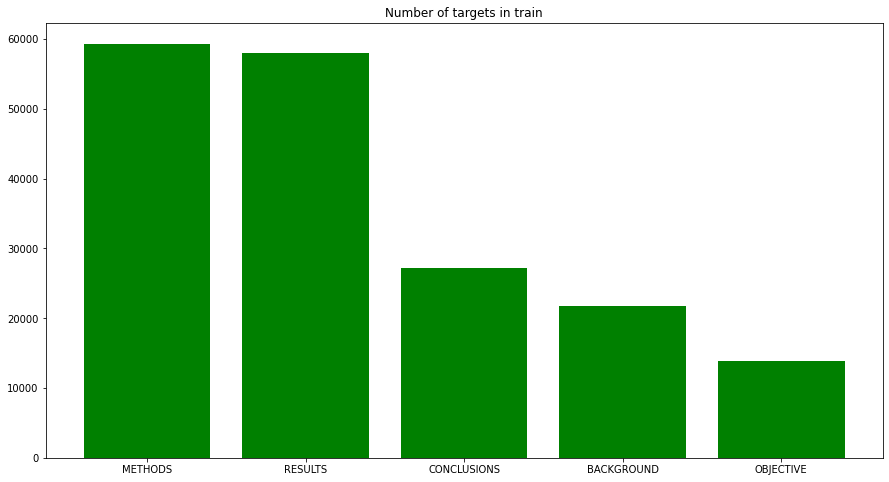

In [77]:
plt.figure(figsize=(15, 8))
plt.title("Number of targets in train")
plt.bar(train_df.target.value_counts().index, train_df.target.value_counts().values, color="green")

<BarContainer object of 5 artists>

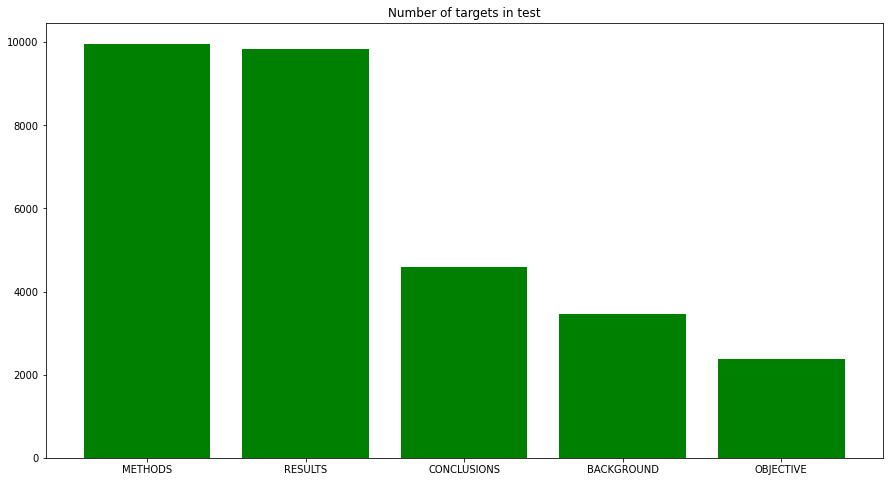

In [78]:
plt.figure(figsize=(15, 8))
plt.title("Number of targets in test")
plt.bar(test_df.target.value_counts().index, test_df.target.value_counts().values, color="green")

In [79]:
train_df.sample(20)

,target,text,line_number,total_lines
163443,RESULTS,the hospital stay in tlh group was shorter tha...,9,13
173288,OBJECTIVE,the aim of this study was to investigate the e...,0,12
105003,CONCLUSIONS,no statistically significant differences were ...,15,16
2782,RESULTS,fifty-four african american patients were enro...,7,13
9272,RESULTS,"in the treatment group , @ patient developed r...",8,11
52787,OBJECTIVE,the use of biodegradable-polymer drug-eluting ...,0,7
130961,RESULTS,after a median follow up of @ years ( iqr @-@ ...,10,14
77129,RESULTS,the mean core-om score was @ ( sd @ ) with @ %...,8,14
155646,METHODS,retrospective clinical study .,1,19
50250,OBJECTIVE,aside from the multikinase inhibitor sorafenib...,0,15


### Top words in each target

In [80]:
method_df = train_df[train_df["target"] == "METHODS"]
result_df = train_df[train_df["target"] == "RESULTS"]
background_df = train_df[train_df["target"] == "BACKGROUND"]
objective_df = train_df[train_df["target"] == "OBJECTIVE"]
conclusion_df = train_df[train_df["target"] == "CONCLUSIONS"]

In [81]:
def create_corpus(target):
    corpus=[]
    
    for x in target['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [82]:
method_corpus = create_corpus(method_df)
result_corpus = create_corpus(result_df)
background_corpus = create_corpus(background_df)
objective_corpus = create_corpus(objective_df)
conclusion_corpus = create_corpus(conclusion_df)

In [83]:
# Hardcoding some undesirable 'words' in corpus
STOPWORDS.add('.')
STOPWORDS.add('@')
STOPWORDS.add(',')
STOPWORDS.add(')')
STOPWORDS.add('(')
STOPWORDS.add('=')
STOPWORDS.add(';')
STOPWORDS.add('%')
STOPWORDS.add('p')
STOPWORDS.add('<')
STOPWORDS.add('-@')
STOPWORDS.add('@-@')
STOPWORDS.add('n')
STOPWORDS.add(':')
STOPWORDS.add('-lsb-')
STOPWORDS.add('-rsb-')
stop_words = set(STOPWORDS)

In [84]:
method_corpus = [w for w in method_corpus if not w.lower() in stop_words]
result_corpus = [w for w in result_corpus if not w.lower() in stop_words]
background_corpus = [w for w in background_corpus if not w.lower() in stop_words]
objective_corpus = [w for w in objective_corpus if not w.lower() in stop_words]
conclusion_corpus = [w for w in conclusion_corpus if not w.lower() in stop_words]

<BarContainer object of 10 artists>

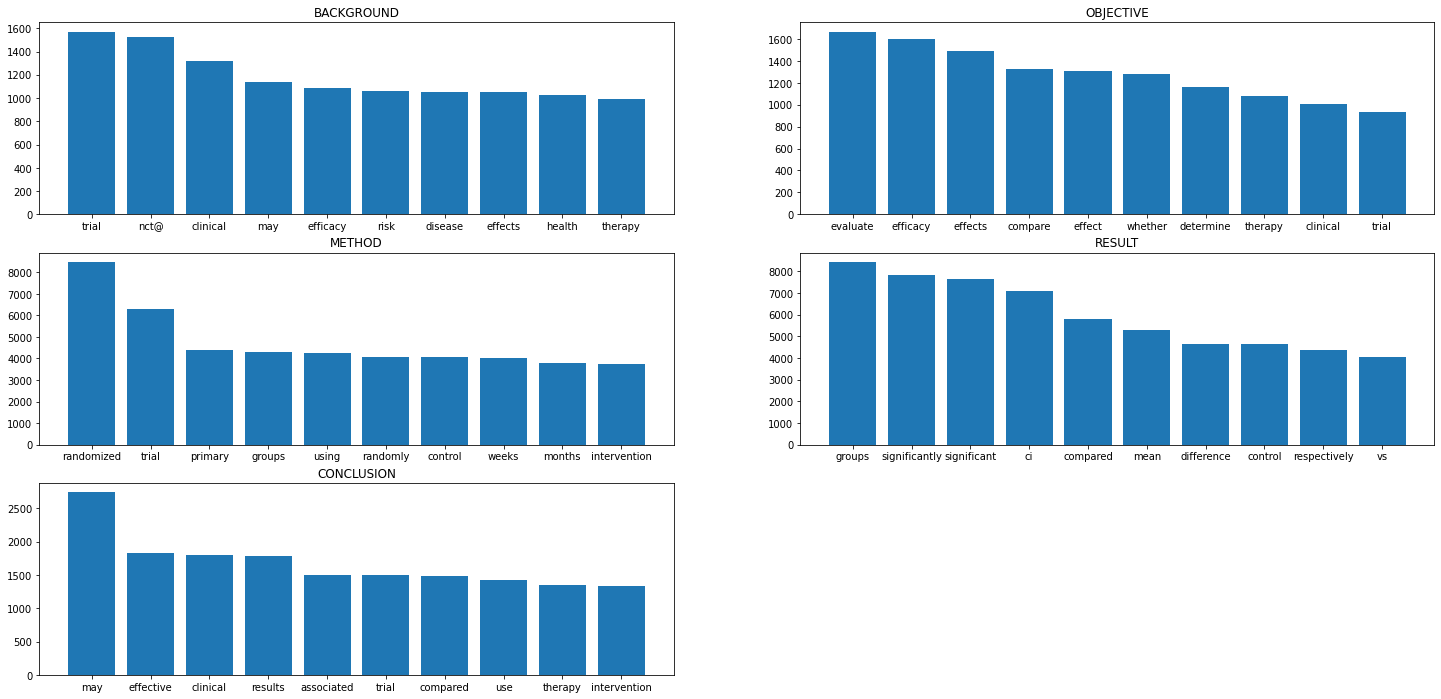

In [85]:
plt.figure(figsize=(25, 12))

plt.subplot(3, 2, 1)
plt.title("BACKGROUND")
plt.bar(pd.Series(background_corpus).value_counts()[:10].index, pd.Series(background_corpus).value_counts()[:10].values)

plt.subplot(3, 2, 2)
plt.title("OBJECTIVE")
plt.bar(pd.Series(objective_corpus).value_counts()[:10].index, pd.Series(objective_corpus).value_counts()[:10].values)

plt.subplot(3, 2, 3)
plt.title("METHOD")
plt.bar(pd.Series(method_corpus).value_counts()[:10].index, pd.Series(method_corpus).value_counts()[:10].values)

plt.subplot(3, 2, 4)
plt.title("RESULT")
plt.bar(pd.Series(result_corpus).value_counts()[:10].index, pd.Series(result_corpus).value_counts()[:10].values)

plt.subplot(3, 2, 5)
plt.title("CONCLUSION")
plt.bar(pd.Series(conclusion_corpus).value_counts()[:10].index, pd.Series(conclusion_corpus).value_counts()[:10].values)

#### More visualization without common words

In [86]:
STOPWORDS.add('patients')
STOPWORDS.add('study')
STOPWORDS.add('treatment')
STOPWORDS.add('group')
stop_words = set(STOPWORDS)

In [87]:
method_corpus = [w for w in method_corpus if not w.lower() in stop_words]
result_corpus = [w for w in result_corpus if not w.lower() in stop_words]
background_corpus = [w for w in background_corpus if not w.lower() in stop_words]
objective_corpus = [w for w in objective_corpus if not w.lower() in stop_words]
conclusion_corpus = [w for w in conclusion_corpus if not w.lower() in stop_words]

<BarContainer object of 10 artists>

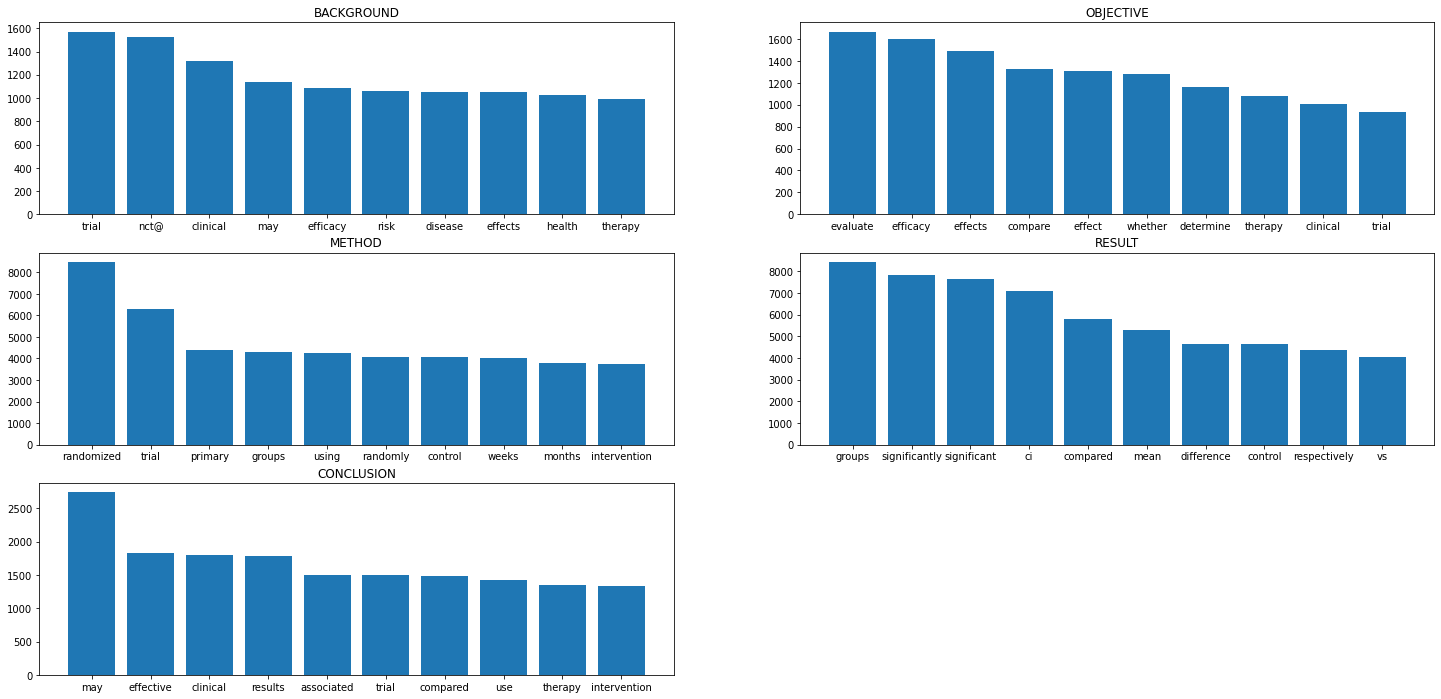

In [88]:
plt.figure(figsize=(25, 12))

plt.subplot(3, 2, 1)
plt.title("BACKGROUND")
plt.bar(pd.Series(background_corpus).value_counts()[:10].index, pd.Series(background_corpus).value_counts()[:10].values)

plt.subplot(3, 2, 2)
plt.title("OBJECTIVE")
plt.bar(pd.Series(objective_corpus).value_counts()[:10].index, pd.Series(objective_corpus).value_counts()[:10].values)

plt.subplot(3, 2, 3)
plt.title("METHOD")
plt.bar(pd.Series(method_corpus).value_counts()[:10].index, pd.Series(method_corpus).value_counts()[:10].values)

plt.subplot(3, 2, 4)
plt.title("RESULT")
plt.bar(pd.Series(result_corpus).value_counts()[:10].index, pd.Series(result_corpus).value_counts()[:10].values)

plt.subplot(3, 2, 5)
plt.title("CONCLUSION")
plt.bar(pd.Series(conclusion_corpus).value_counts()[:10].index, pd.Series(conclusion_corpus).value_counts()[:10].values)

## Sentence Length in each target

In [89]:
background_len = background_df["text"].str.split(' ').map(lambda x: len(x))
objective_len = objective_df["text"].str.split(' ').map(lambda x: len(x))
method_len = method_df["text"].str.split(' ').map(lambda x: len(x))
result_len = result_df["text"].str.split(' ').map(lambda x: len(x))
conclusion_len = conclusion_df["text"].str.split(' ').map(lambda x: len(x))

(array([ 518., 5509., 9624., 6785., 3207., 1104.,  297.,   83.,   23.,
          13.]),
 array([ 0.,  8., 16., 24., 32., 40., 48., 56., 64., 72., 80.]),
 <a list of 10 Patch objects>)

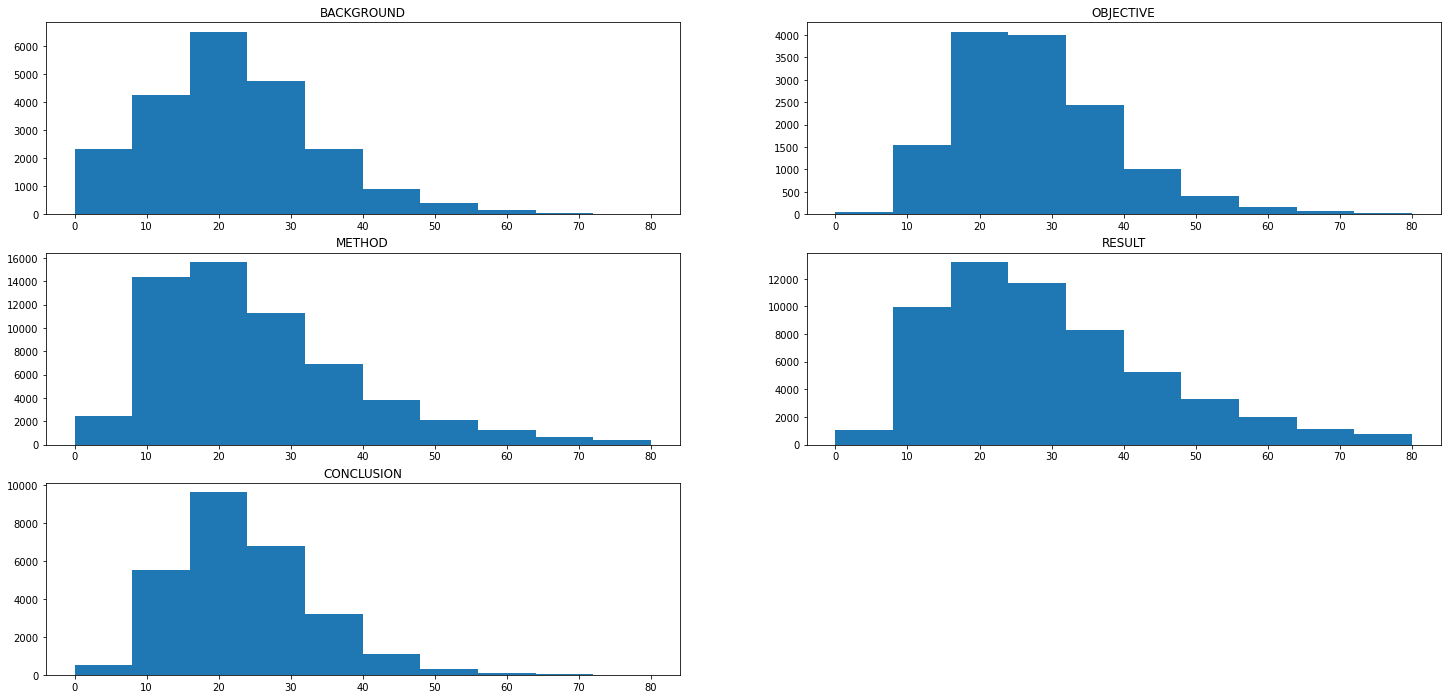

In [90]:
plt.figure(figsize=(25, 12))

plt.subplot(3, 2, 1)
plt.title("BACKGROUND")
plt.hist(background_len, range=(0, 80));

plt.subplot(3, 2, 2)
plt.title("OBJECTIVE")
plt.hist(objective_len, range=(0, 80))

plt.subplot(3, 2, 3)
plt.title("METHOD")
plt.hist(method_len, range=(0, 80))

plt.subplot(3, 2, 4)
plt.title("RESULT")
plt.hist(result_len, range=(0, 80))

plt.subplot(3, 2, 5)
plt.title("CONCLUSION")
plt.hist(conclusion_len, range=(0, 80))

## Average Word length in each target

In [91]:
background_avg_len = background_df["text"].str.split(' ').map(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x))
objective_avg_len = objective_df["text"].str.split(' ').map(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x))
method_avg_len = method_df["text"].str.split(' ').map(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x))
result_avg_len = result_df["text"].str.split(' ').map(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x))
conclusion_avg_len = conclusion_df["text"].str.split(' ').map(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x))

(array([6.0000e+00, 5.2000e+01, 2.2230e+03, 1.8509e+04, 6.1280e+03,
        2.3700e+02, 1.0000e+01, 2.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <a list of 10 Patch objects>)

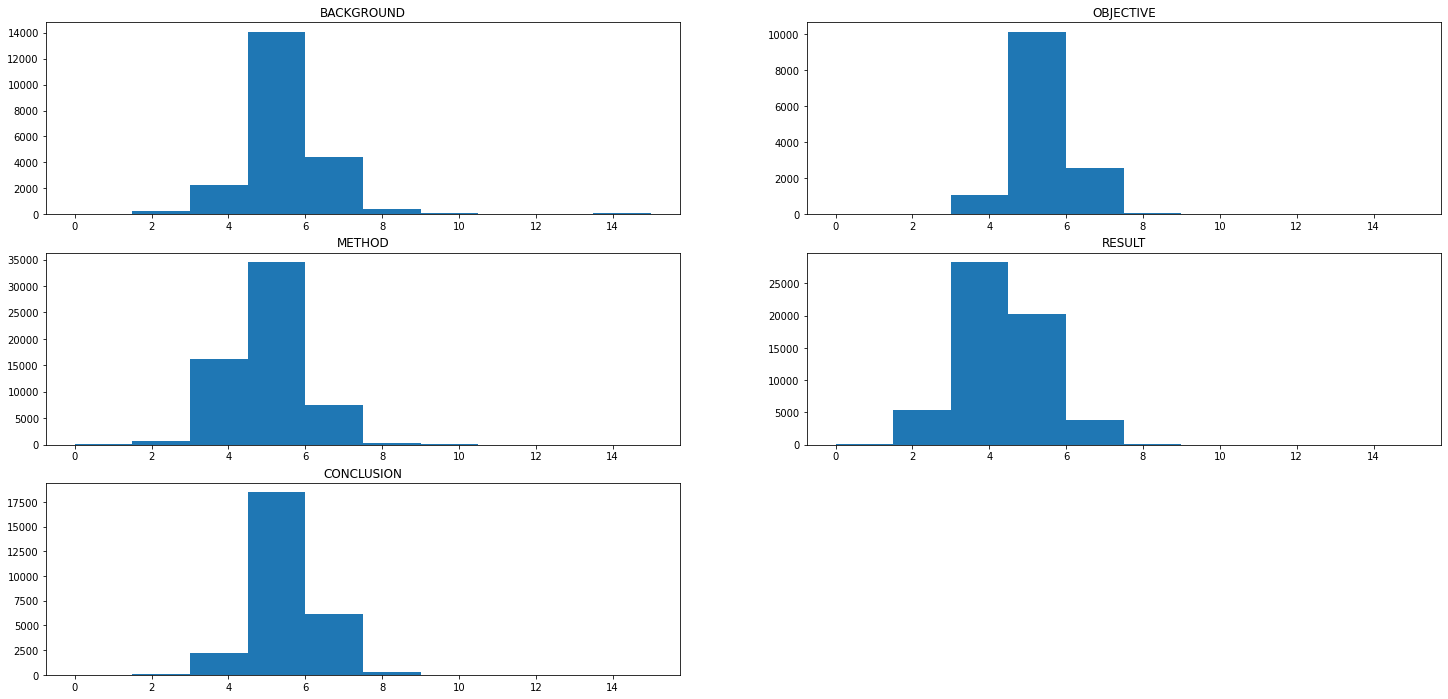

In [92]:
plt.figure(figsize=(25, 12))

plt.subplot(3, 2, 1)
plt.title("BACKGROUND")
plt.hist(background_avg_len, range=(0, 15));

plt.subplot(3, 2, 2)
plt.title("OBJECTIVE")
plt.hist(objective_avg_len, range=(0, 15))

plt.subplot(3, 2, 3)
plt.title("METHOD")
plt.hist(method_avg_len, range=(0, 15))

plt.subplot(3, 2, 4)
plt.title("RESULT")
plt.hist(result_avg_len, range=(0, 15))

plt.subplot(3, 2, 5)
plt.title("CONCLUSION")
plt.hist(conclusion_avg_len, range=(0, 15))

# BERT

There is a memory issue, due to high embedding removing outlier

In [93]:
outlier = train_df.text.str.split(' ').map(lambda x: len(x))

In [94]:
np.max(outlier), np.median(outlier), np.max(outlier), np.min(outlier), np.percentile(outlier, 95), len(outlier)

(296, 23.0, 296, 1, 55.0, 180040)

In [95]:
outlier_test = test_df.text.str.split(' ').map(lambda x: len(x))
np.max(outlier_test), np.median(outlier_test), np.max(outlier_test), np.min(outlier_test), np.percentile(outlier_test, 95), len(outlier_test)

(258, 23.0, 258, 1, 55.0, 30212)

In [96]:
train_df = train_df[train_df.text.str.split(' ').map(lambda x: len(x)).map(lambda x: x <= 55)]
test_df = test_df[test_df.text.str.split(' ').map(lambda x: len(x)).map(lambda x: x <= 55)]

In [97]:
train_df.drop(['line_number', 'total_lines'], axis=1, inplace=True)

In [98]:
test_df.drop(['line_number', 'total_lines'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [99]:
train_df.isna().sum(), test_df.isna().sum()

(target    0
 text      0
 dtype: int64, target    0
 text      0
 dtype: int64)

In [100]:
train_df.target.value_counts()

METHODS        56693
RESULTS        52820
CONCLUSIONS    27044
BACKGROUND     21493
OBJECTIVE      13552
Name: target, dtype: int64

In [101]:
switcher = {
          "BACKGROUND": 0,
          "OBJECTIVE": 1,
          "METHODS": 2,
          "RESULTS": 3,
          "CONCLUSIONS": 4,
      }

In [102]:
train_df.target = train_df.target.map(lambda x: switcher.get(x))
train_df

,target,text
0,1,to investigate the efficacy of @ weeks of dail...
1,2,a total of @ patients with primary knee oa wer...
2,2,outcome measures included pain reduction and i...
3,2,pain was assessed using the visual analog pain...
4,2,secondary outcome measures included the wester...
...,...,...
180034,3,the combination of atorvastatin/ezetimibe resu...
180036,3,"for pav , a significantly greater percentage o..."
180037,3,both strategies had acceptable side effect pro...
180038,4,"compared with standard statin monotherapy , th..."


In [103]:
test_df.target = test_df.target.map(lambda x: switcher.get(x))
test_df

,target,text
0,0,ige sensitization to aspergillus fumigatus and...
1,0,it is not clear whether these patients would b...
2,1,we sought to determine whether a @-month cours...
3,2,asthmatic patients who were ige sensitized to ...
4,2,primary outcomes were improvement in quality o...
...,...,...
30207,3,pruritus occurred more frequently with the act...
30208,3,three patients in the active-regimen group ( @...
30209,3,hemoglobin values of grade @ ( @ to < @ g per ...
30210,4,rates of response to a @-week interferon-free ...


In [104]:
train_ds = Dataset.from_pandas(train_df)
train_ds

Dataset({
    features: ['target', 'text', '__index_level_0__'],
    num_rows: 171602
})

In [105]:
test_ds = Dataset.from_pandas(test_df)
test_ds

Dataset({
    features: ['target', 'text', '__index_level_0__'],
    num_rows: 28765
})

In [106]:
train_ds = train_ds.remove_columns("__index_level_0__")
test_ds = test_ds.remove_columns("__index_level_0__")

In [107]:
train_ds = train_ds.rename_column("target", "label")
test_ds = test_ds.rename_column("target", "label")

In [108]:
train_ds, test_ds

(Dataset({
     features: ['label', 'text'],
     num_rows: 171602
 }), Dataset({
     features: ['label', 'text'],
     num_rows: 28765
 }))

In [109]:
train_ds[0]

{'label': 1,
 'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .'}

In [110]:
test_ds[0]

{'label': 0,
 'text': 'ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .'}

In [111]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [112]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [113]:
tokenized_train_ds = train_ds.map(preprocess_function, batched=True)
tokenized_test_ds = test_ds.map(preprocess_function, batched=True)

  0%|          | 0/172 [00:00<?, ?ba/s]

  0%|          | 0/29 [00:00<?, ?ba/s]

In [114]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')

In [115]:
tf_train_set = tokenized_train_ds.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=True,
    batch_size=4,
    collate_fn=data_collator
)

tf_test_set = tokenized_test_ds.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=True,
    batch_size=4,
    collate_fn=data_collator
)

In [116]:
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [117]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=tf.metrics.SparseCategoricalAccuracy())

In [118]:
model.fit(x=tf_train_set, validation_data=tf_test_set, epochs=3)

Epoch 1/3
42900/42900 [==============================] - 3901s 91ms/step - loss: 0.5012 - sparse_categorical_accuracy: 0.8220 - val_loss: 0.3860 - val_sparse_categorical_accuracy: 0.8576
Epoch 2/3
42900/42900 [==============================] - 3870s 90ms/step - loss: 0.3821 - sparse_categorical_accuracy: 0.8615 - val_loss: 0.3579 - val_sparse_categorical_accuracy: 0.8677
Epoch 3/3
42900/42900 [==============================] - 3865s 90ms/step - loss: 0.3529 - sparse_categorical_accuracy: 0.8719 - val_loss: 0.3540 - val_sparse_categorical_accuracy: 0.8696


In [120]:
model.evaluate(tf_test_set)

7191/7191 [==============================] - 265s 37ms/step - loss: 0.3540 - sparse_categorical_accuracy: 0.8696


[0.3540409505367279, 0.8695939183235168]

In [119]:
model.save_pretrained('my-awesome-model')

In [121]:
!zip -r /content/file.zip /content/my-awesome-model

  adding: content/my-awesome-model/ (stored 0%)
  adding: content/my-awesome-model/tf_model.h5 (deflated 7%)
  adding: content/my-awesome-model/config.json (deflated 52%)


In [122]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>